# 09. Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset we'll be using) is avaiable is: [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here [Neural networks for joint sentence classification in medical paper abstracts.](https://arxiv.org/pdf/1612.05251.pdf)

If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fc9ae116-f6c4-7eed-15fb-c42b4e3666d5)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.
We can do so from the authors GitHub https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20K dataset with number replaced with @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to  become with it.

And one of the best ways to become one with the data is to...
> Visualize, visualize, visualize

So with that in mind, let's write a funciton to read

In [ ]:
#  Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, 'r') as f:
      return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+'train.txt') # read the lines with the training file
train_lines[:14]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look

How I think our data would be best represented...

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

Let's write a funciton which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [ ]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
        filename: a string of the target text file to read and extract line data
        from.

    Returns:
        A list of dictionaries each containing a line from an abstract,
        the lines label, the lines position in the abstract and the total number
        of lines in the abstract where the line is from. For example:

        [{"target": 'CONCLUSION',
            "text": The study couldn't have gone better, turns out people are kinder than you think",
            "line_number": 8,
            "total_lines": 8}]
    """

    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empy abstract
    abstract_samples = []

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): #Check to see if the line is an ID line
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

            # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split('\t') # split target label from text
                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get tharget text and lower it
                line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
                line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (we want to start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
        
    return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt') # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 557 ms, sys: 135 ms, total: 692 ms
Wall time: 705 ms


In [ ]:
# Check the first abstract of the training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

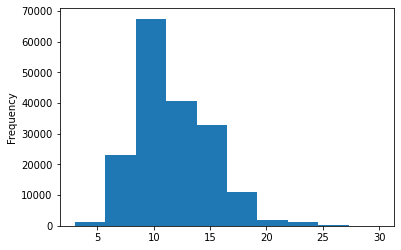

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist() # Most of the abstracts are around 10 sentences long

In [ ]:
# get lists of sentences
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML models requrie numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
# sparse=True will conpress the matrix to save memeory
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-spare matrix, tensorflow is incompatible with sparse matrix data-type
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1)) # one_hot_encoder has already been fit on train data so we just need to use transform on the test and validation dat
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
# ValueError: Expected 2D array, got 1D array instead:

# check what one hot encoder labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# import tensorflow as tf
# tf.constant(train_labels_one_hot)
# gives an error if sparse=True in one hot encoder

### Label encode labels

In [ ]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and see which one works best.

And as always, we're going to start with a baseline (TF_IDF Multinomial Naive Bayes classifier)


## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baselie model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

## Download helper functions
In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewritting it, let's download it from our helper function script

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-16 09:29:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-16 09:29:13 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building models, we've got to create vectorization and embedding layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

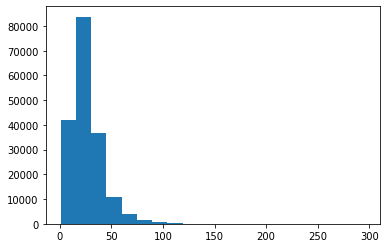

In [ ]:
# What the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples
# 95% of the sentences are less that 55 words long
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len


55

In [ ]:
# Max sentence length
max(sent_lens)

296

## Crate text vectorizer layer

We want to make a layer which maps our texts from words to number

In [ ]:
# How many words are in our vocabulary? (takemn from table 2 in https://arxiv.org/abs/1710.06071)
max_tokens = 68000

In [ ]:
# Create text vecotrizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequence

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
they were randomized to receive intravenous linezolid infusion ( @ mg/@ @ hours , @ mg/@ hours , or @ mg/@ hours ) in three periods with washout periods of @ days between each dosage .

Length of text: 36

Vectorized text: [[ 316    9   29    6  175  511 7053  525   68  227   68  227   16   68
   227    5  134 1242    7 1611 1242    4   84   30  122 1526    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
 # Get the config of our text vectorizer
 text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # Use masking to handle variable sequence lengths (save space))
                               name='token_embedding')

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 they were randomized to receive intravenous linezolid infusion ( @ mg/@ @ hours , @ mg/@ hours , or @ mg/@ hours ) in three periods with washout periods of @ days between each dosage .

Sentence after vectorization (before embedding):
 [[ 316    9   29    6  175  511 7053  525   68  227   68  227   16   68
   227    5  134 1242    7 1611 1242    4   84   30  122 1526    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.0006673  -0.01391513 -0.04445592 ...  0.01712698 -0.04749301
   -0.00348223]
  [ 0.01839311  0.0148146   0.02537626 ... -0.03346239 -0.04526224
    0.01241993]
  [-0.02888353 -0.01315055  0.01617337 ...  0.0302658   0.02195442
   -0.044927  ]
  ...
  [ 0.0181885  -0.0136273  -0.04267613 ... -0.04018165 -0.01723389
   -0.00125798]
  [ 0.0181885  -0.0136273  -0.04267613 ... -0.04018165 -0.01723389
   -0.00125798]

## Createing datasets (making sure our data loads as fast as possible)


We are going to setup our data to run as possible with the Tensorflow tf.data API, many of the steps here are discussed at length in these tow resources:

* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset
# the train_sentences have shape () as each sentence is a variable shape

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset =  valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1 : Conv1D with token embeddings

In [ ]:
# Create 1D conv mode to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
len(train_dataset)
# 5627 batches
# total data = 5627 * 32

5627

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # only look at 10% of batcbes ie 562 batches,
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 21s 8ms/step - loss: 0.9193 - accuracy: 0.6352 - val_loss: 0.6810 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6534 - accuracy: 0.7583 - val_loss: 0.6241 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6137 - accuracy: 0.7767 - val_loss: 0.5963 - val_accuracy: 0.7836


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5978 - accuracy: 0.7864


[0.5978314280509949, 0.7864424586296082]

In [ ]:
# Make predictions (our model predicts prediciton probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.8339358e-01, 1.2555645e-01, 9.1516323e-02, 2.7340391e-01,
         2.6129754e-02],
        [4.3232065e-01, 2.6406422e-01, 1.3438574e-02, 2.8350067e-01,
         6.6758059e-03],
        [1.5309475e-01, 7.7996259e-03, 9.4052328e-04, 8.3814704e-01,
         1.8111183e-05],
        ...,
        [7.7261029e-06, 6.2642904e-04, 4.9296406e-04, 2.8485561e-06,
         9.9886996e-01],
        [6.6946171e-02, 3.8842329e-01, 1.4438680e-01, 7.2937191e-02,
         3.2730651e-01],
        [1.1882919e-01, 7.2695178e-01, 2.8175224e-02, 4.1749805e-02,
         8.4293976e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.64424731894611,
 'f1': 0.7839818723108997,
 'precision': 0.7832761441382025,
 'recall': 0.7864424731894611}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embedding from TensorFlow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4


The paper originally used GloVe emeddings, however, we're going to stick with the later created USE pretrained embedding

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
# Test our the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_train_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding\n{use_embedding_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedding_sentence[0])}")

Random training sentence:
forty healthy male volunteers were chosen and divided into experimental group and control group randomly .
Sentence after embedding
[-0.04972322 -0.04673712  0.01888287  0.04744433  0.00803785  0.01250609
  0.06852686 -0.07053629 -0.0634091  -0.02860644  0.07158074  0.03368735
  0.07818437 -0.03663044 -0.03087803  0.00245109 -0.06146752  0.05521512
 -0.03919192 -0.02951389  0.01046388 -0.00051774 -0.04420996  0.01622137
  0.01295406  0.04121117 -0.058877    0.07029916 -0.01133262  0.06741151]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrianed_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of 512
x = layers.Dense(128, activation='relu')(pretrianed_embedding) # add a fully connected layer on top of the embedding
# Note: we could add more layers here if you want to
outputs = layers.Dense(num_classes, activation='softmax')(x) # create the output layer

model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 17ms/step - loss: 0.9176 - accuracy: 0.6496 - val_loss: 0.7961 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7683 - accuracy: 0.7023 - val_loss: 0.7535 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7507 - accuracy: 0.7126 - val_loss: 0.7376 - val_accuracy: 0.7161


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 13ms/step - loss: 0.7403 - accuracy: 0.7160


[0.7402747869491577, 0.7159737944602966]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs.shape

(30212, 5)

In [ ]:
# Conver the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.59737852508937,
 'f1': 0.7128673921188982,
 'precision': 0.7161706235774631,
 'recall': 0.7159737852508937}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states that they used a combination of token and character-level embeddings

Previously we've used token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Create a character-level tokenizer

In [ ]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [ ]:
# Make function to split sentences into charactes
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequences inot charactes
split_chars(random_train_sentence)

'f o r t y   h e a l t h y   m a l e   v o l u n t e e r s   w e r e   c h o s e n   a n d   d i v i d e d   i n t o   e x p e r i m e n t a l   g r o u p   a n d   c o n t r o l   g r o u p   r a n d o m l y   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# What the average charadter length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

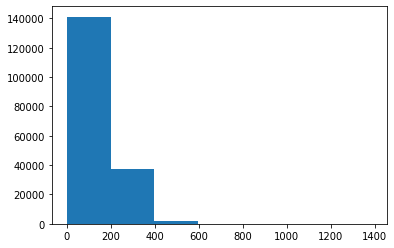

In [ ]:
# Check the distribution of our sequences at the character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV =out of vocab ['UNK'])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                 output_sequence_length=output_seq_char_len,
                                 standardize='lower_and_strip_punctuation', # set standardization to None if you want to keep punctuation
                                 name='char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of differenct characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of differenct characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 i n   b o t h   g r o u p s   ,   t h e   m o d i f i e d   a s h w o r t h   s c a l e   d e c r e a s e d   ,   g m f m   a n d   e x t e n s i o n   a n g l e   o f   h i p   j o i n t s   i n c r e a s e d   a f t e r   e i g h t   w e e k s   .

Length of random_train_chars: 104

Vectorized chars:
[[ 4  6 22  7  3 13 18  8  7 16 14  9  3 13  2 15  7 10  4 17  4  2 10  5
   9 13 20  7  8  3 13  9 11  5 12  2 10  2 11  8  2  5  9  2 10 18 15 17
  15  5  6 10  2 24  3  2  6  9  4  7  6  5  6 18 12  2  7 17 13  4 14 27
   7  4  6  3  9  4  6 11  8  2  5  9  2 10  5 17  3  2  8  2  4 18 13  3
  20  2  2 23  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

In [ ]:
## Create a character level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,  # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False,
                              name='char_embed')

In [ ]:
# Test our character embedding layer
print(f"Charified text (before vecotrization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vecotrization and embedding):
i n   b o t h   g r o u p s   ,   t h e   m o d i f i e d   a s h w o r t h   s c a l e   d e c r e a s e d   ,   g m f m   a n d   e x t e n s i o n   a n g l e   o f   h i p   j o i n t s   i n c r e a s e d   a f t e r   e i g h t   w e e k s   .

Embedded chars (after vectorization and embedding):
 [[[-0.00329045  0.01788199  0.0442739  ... -0.00263032 -0.01826807
   -0.02772078]
  [-0.00993516 -0.02743409 -0.01849997 ...  0.01869366  0.01656585
   -0.02611091]
  [ 0.00270321 -0.02894752  0.0195738  ... -0.03165207 -0.00391474
   -0.01728263]
  ...
  [-0.04036099 -0.00428301  0.03821808 ... -0.00222279  0.04029414
    0.03974203]
  [-0.04036099 -0.00428301  0.03821808 ... -0.00222279  0.04029414
    0.03974203]
  [-0.04036099 -0.00428301  0.03821808 ... -0.00222279  0.04029414
    0.03974203]]]

Character embedding shape: (1, 290, 25)


In [ ]:
## Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3_conv1d_char_embeddings')

# compile model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasetes
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2710 - accuracy: 0.4895 - val_loss: 1.0563 - val_accuracy: 0.5838
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0270 - accuracy: 0.5904 - val_loss: 0.9639 - val_accuracy: 0.6253
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9447 - accuracy: 0.6297 - val_loss: 0.8894 - val_accuracy: 0.6582


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.9115 - accuracy: 0.6460


[0.9114875793457031, 0.6460347175598145]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17019944, 0.3559538 , 0.06125084, 0.38656765, 0.02602834],
       [0.19249628, 0.52117467, 0.02037037, 0.154765  , 0.11119368],
       [0.12512489, 0.33946833, 0.13959076, 0.3103736 , 0.08544246],
       ...,
       [0.01428985, 0.0306867 , 0.09183453, 0.01884332, 0.84434557],
       [0.01490158, 0.0339868 , 0.43887195, 0.01231065, 0.49992907],
       [0.4094339 , 0.43857646, 0.10347632, 0.04076326, 0.00775002]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.60346882033629,
 'f1': 0.6346771800985408,
 'precision': 0.6382329147072117,
 'recall': 0.6460346882033629}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors =  char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenat token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_droput = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_droput) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')


In [ ]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

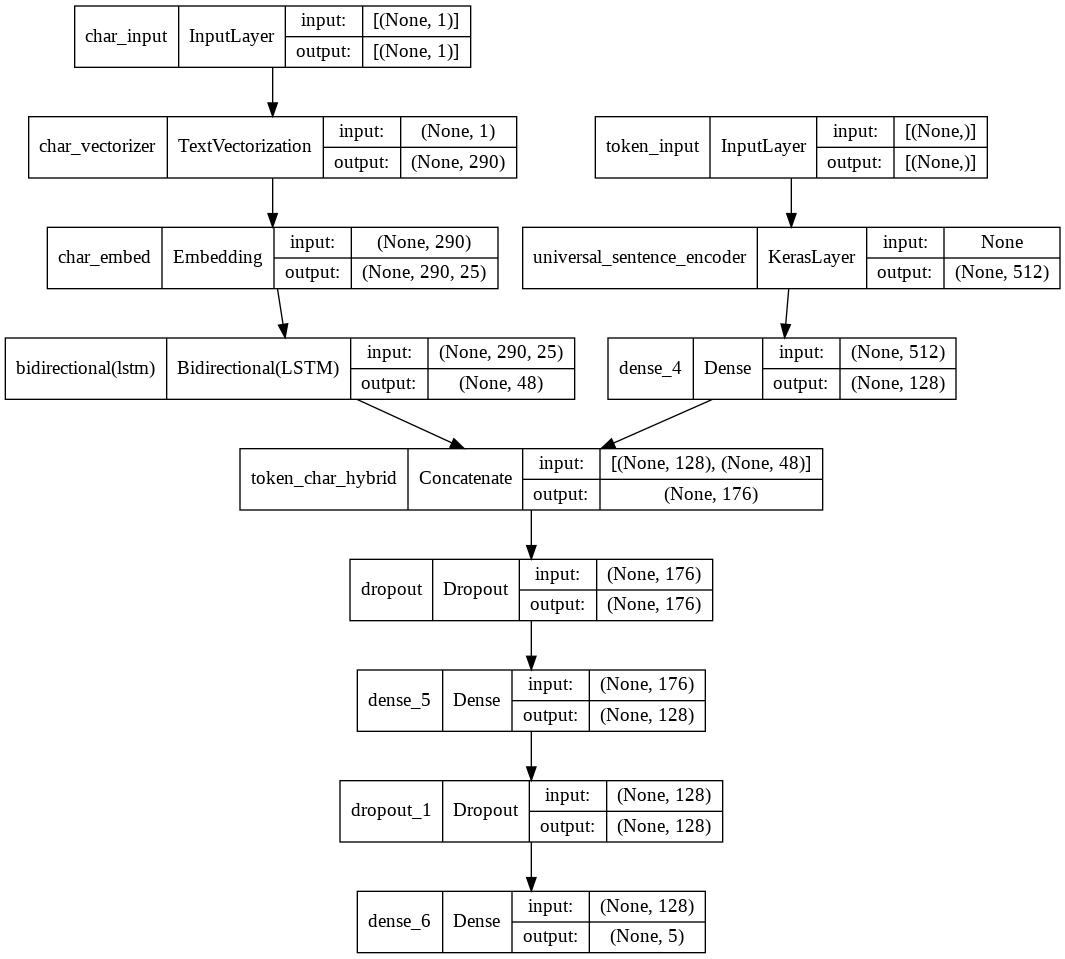

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),  # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=['accuracy'])

### Combining tokane and character data in a tf.data dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

#train_char_token_dataset = tf.data.Dataset.from_tensor_slices(list(zip((train_sentences, train_chars), train_labels_one_hot))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Repeat the above steps for the validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

Understanding tf.data.Dataset.from_tensor_slices

Removes the first dimension and groups the remaining by the first dimension

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 31s 47ms/step - loss: 0.9940 - accuracy: 0.6049 - val_loss: 0.8039 - val_accuracy: 0.6938
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.8045 - accuracy: 0.6917 - val_loss: 0.7239 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7746 - accuracy: 0.7062 - val_loss: 0.6965 - val_accuracy: 0.7394


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 25s 27ms/step - loss: 0.6993 - accuracy: 0.7320


[0.6992886066436768, 0.7319939136505127]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.7224171e-01, 4.2510268e-01, 3.4719072e-03, 1.9401087e-01,
        5.1728231e-03],
       [3.0363375e-01, 4.8770222e-01, 3.8692947e-03, 2.0330161e-01,
        1.4930753e-03],
       [3.0837852e-01, 1.6029847e-01, 6.1767850e-02, 4.2710915e-01,
        4.2446062e-02],
       ...,
       [5.2910182e-04, 1.0270743e-02, 4.8795588e-02, 2.6643480e-04,
        9.4013810e-01],
       [4.7561820e-03, 4.5449767e-02, 2.3722714e-01, 2.3288184e-03,
        7.1023810e-01],
       [4.2229760e-01, 2.8207508e-01, 2.0779994e-01, 3.1722672e-02,
        5.6104723e-02]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                            y_pred=model_4_preds)
model_4_results

{'accuracy': 73.1993909704753,
 'f1': 0.7285347009489229,
 'precision': 0.7334174473273509,
 'recall': 0.7319939097047531}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note**: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

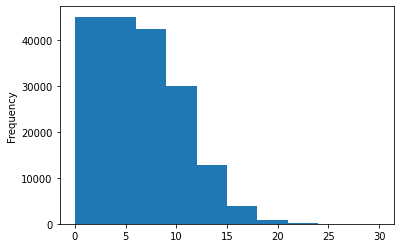

In [ ]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist();

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15) # to prevent the one-hot vector from being too long
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:16], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(16, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total line feature..

In [ ]:
# How many different number of lines are there? (length of different abstracts)
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

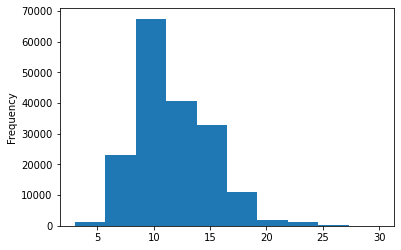

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# check the coverage of "total_lines" values of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" features
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

## Building a tribrid embedding model

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_numbers_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_numbers_inputs)
line_number_model = tf.keras.Model(inputs=line_numbers_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output, total_lines_model.output, z])

# Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# Put the model together
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer, name='tribrid_embedding_model')


In [ ]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

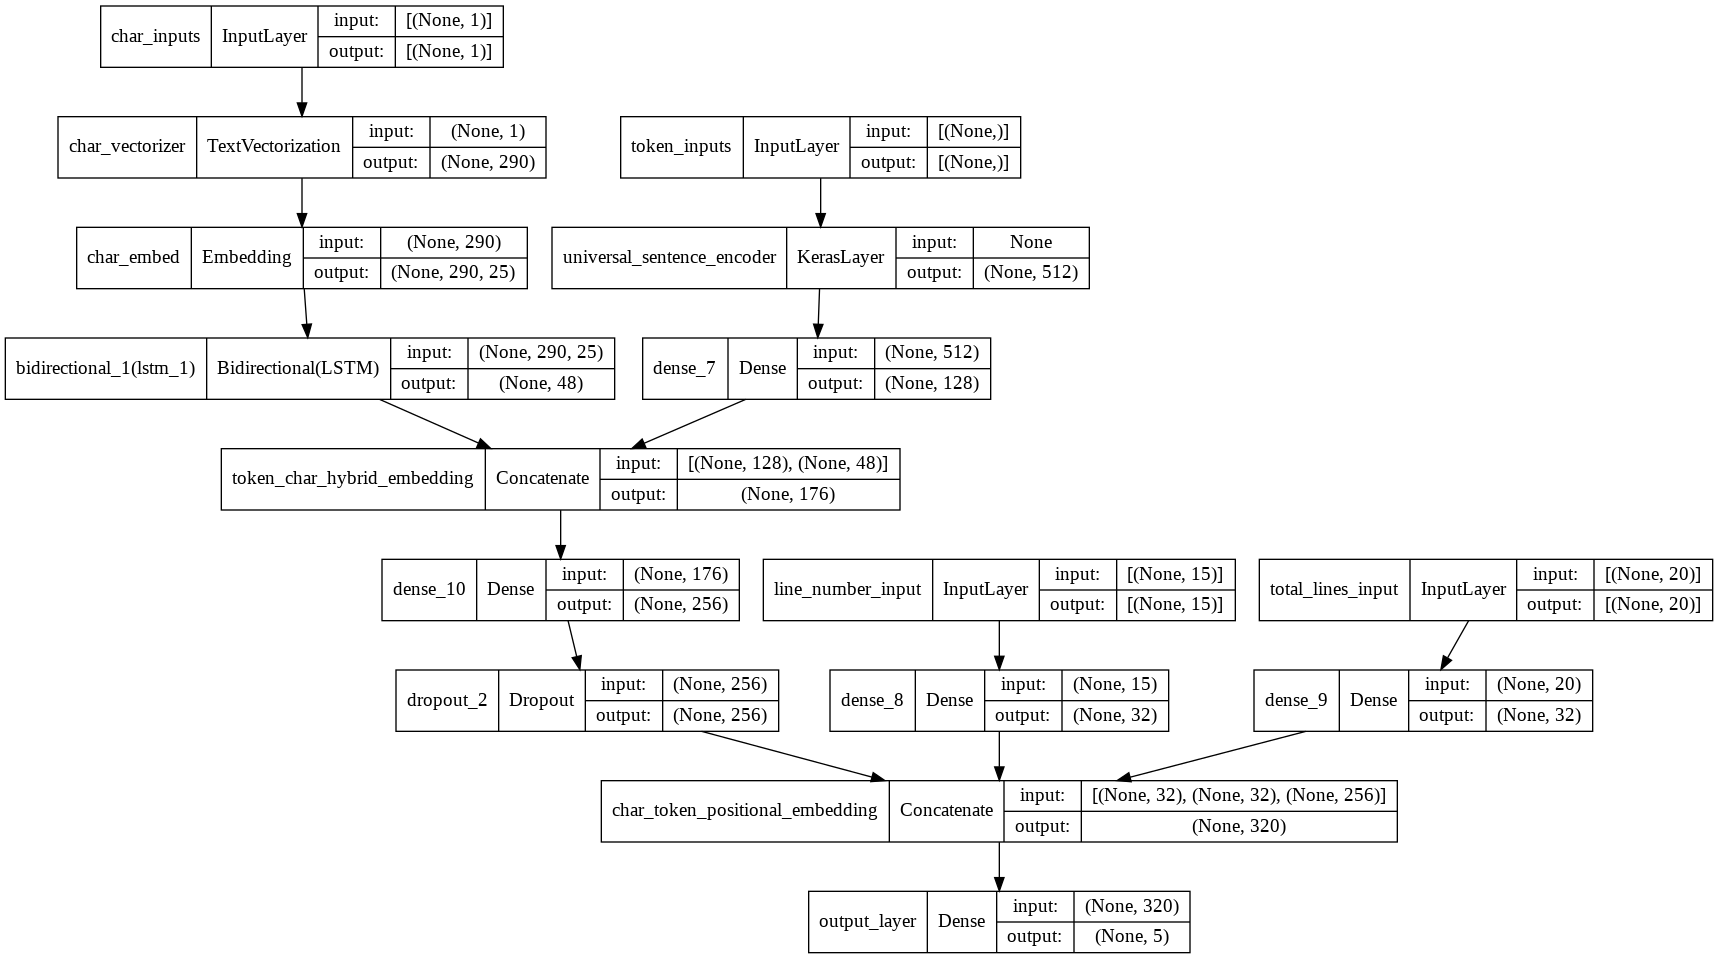

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothin?

For example if our model gets too confident on a single class (e.g. it prediciton probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is that it assings some of the value from the highest pred prob to other classes, in turn, hoepfully imporving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

For more on label_smoothing see this link [Label smoothing with Keras, TensorFlow, and Deep Learning.](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/)

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Cretae tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datsets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit our tfibrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 30s 46ms/step - loss: 1.0994 - accuracy: 0.7217 - val_loss: 0.9889 - val_accuracy: 0.8015
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9691 - accuracy: 0.8153 - val_loss: 0.9515 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9529 - accuracy: 0.8231 - val_loss: 0.9415 - val_accuracy: 0.8275


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 24s 24ms/step


array([[0.5145881 , 0.08910741, 0.00933404, 0.37156188, 0.01540857],
       [0.5378719 , 0.07716849, 0.03329679, 0.3437432 , 0.00791961],
       [0.2541426 , 0.08384458, 0.09727737, 0.5021507 , 0.06258477],
       ...,
       [0.02928932, 0.09423643, 0.04208625, 0.02644056, 0.80794746],
       [0.0273178 , 0.24849978, 0.08028747, 0.02296917, 0.6209258 ],
       [0.21540327, 0.57766724, 0.09491967, 0.04693585, 0.06507394]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.10936051899908,
 'f1': 0.8303133259947306,
 'precision': 0.8301790412022926,
 'recall': 0.8310936051899908}

In [ ]:
model_4_results

{'accuracy': 73.1993909704753,
 'f1': 0.7285347009489229,
 'precision': 0.7334174473273509,
 'recall': 0.7319939097047531}

## Compare model results

In [ ]:
# Combine reuslts into a dataframe
all_model_results = pd.DataFrame({'baseline': baseline_results,
                                  'custom_token_embed_conv1d': model_1_results,
                                  'pretrained_token_embed': model_2_results,
                                  'custom_char_embed_conv1d': model_3_results,
                                  'hybrid_char_token_embed': model_4_results,
                                   'tribrid_pos_char_token_embed': model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.644247,0.783276,0.786442,0.783982
pretrained_token_embed,71.597379,0.716171,0.715974,0.712867
custom_char_embed_conv1d,64.603469,0.638233,0.646035,0.634677
hybrid_char_token_embed,73.199391,0.733417,0.731994,0.728535
tribrid_pos_char_token_embed,83.109361,0.830179,0.831094,0.830313


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

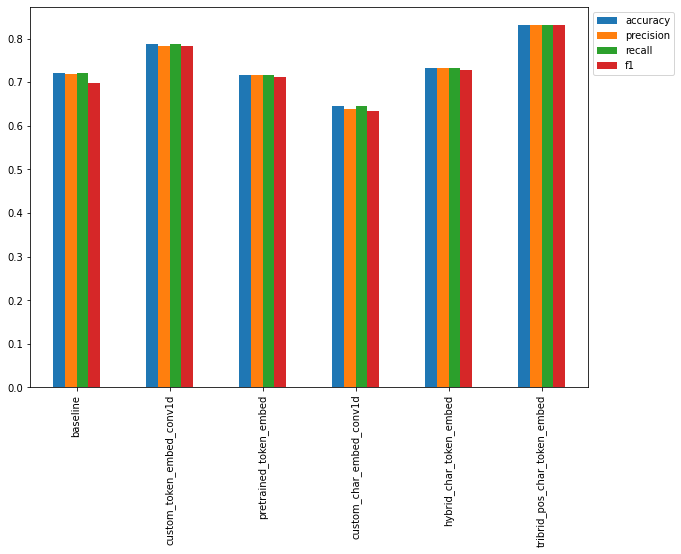

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

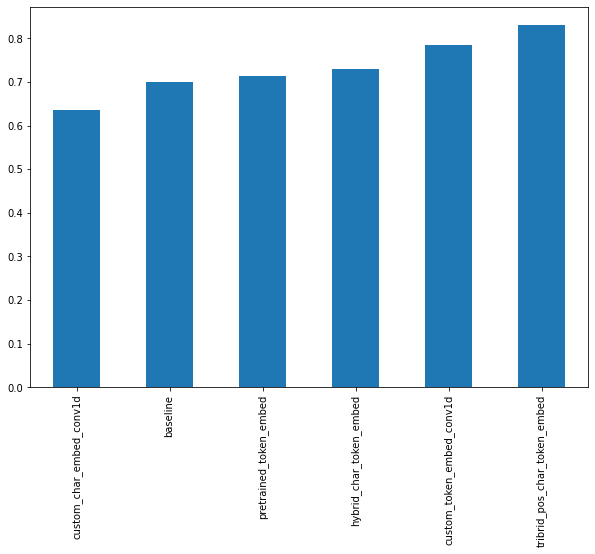

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10, 7));

## Save and load best performing model

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save('skimlit_tribrid_model')

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [ ]:
# Make predicitons with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.07957103137826,
 'f1': 0.8297621124331818,
 'precision': 0.8294349884768478,
 'recall': 0.8307957103137826}

In [ ]:
model_5_results

{'accuracy': 83.10936051899908,
 'f1': 0.8303133259947306,
 'precision': 0.8301790412022926,
 'recall': 0.8310936051899908}

In [ ]:
# check the loaded model summary
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, None)        0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

## Download and load in a pretrained model from Google Storage

In [ ]:
#!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip

In [ ]:
#!mkdir skimlit_gs_model
#!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [ ]:
# Load in downloaded Google Storage model
# There is some issue with the checkpoint in loaded_gs_model
#loaded_gs_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model')

In [ ]:
# Evaluate the loaded Google S
#loaded_gs_model.evaluate(val_char_token_pos_dataset)

## Evaluate on the test dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
# Make predictions on the test datset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset, verbose=1)

test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 194s 206ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate the model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.57839721254355,
 'f1': 0.8247277395093516,
 'precision': 0.8242344224788141,
 'recall': 0.8257839721254355}

### Find the most wrong

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Get list of class names of test predicitons
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:10]

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [ ]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [ ]:
# Create prediction-enriched test dataframe
test_df['prediciton'] = test_pred_classes
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df['correct'] = test_df['prediciton'] == test_df['target']
test_df.head(20)

,target,text,line_number,total_lines,prediciton,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.457478,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.362143,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.783717,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.641974,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.697565,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.885419,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.539957,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.472502,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.446794,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.518761,True


In [ ]:
top_100_wrong = test_df[test_df['correct'] == False].sort_values('pred_prob', ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediciton,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.943814,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.943733,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.937399,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.934734,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.920600,False
...,...,...,...,...,...,...,...
21186,METHODS,mean distraction rates were similar between gr...,8,17,RESULTS,0.840334,False
18003,RESULTS,this formulation produced highly significant a...,12,20,CONCLUSIONS,0.840316,False
18188,RESULTS,a @-arm randomized trial was conducted over @ ...,2,17,METHODS,0.839984,False
8527,OBJECTIVE,participants were randomly allocated to a trea...,2,10,METHODS,0.839057,False


## Make example predictions

In [ ]:
# Download and open example abstracts (copy and pasted from PubMed)

import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open('skimlit_example_abstracts.json', 'r') as f:
    example_abstracts = json.load(f)
example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe('sentencizer') # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]['abstract'])  # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i
    sample_dict['total_lines'] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line['line_number'] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line['total_lines'] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines] 
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions on sample abstract features

test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.31329188, 0.11511163, 0.01805021, 0.525462  , 0.0280844 ],
       [0.08809194, 0.0240681 , 0.6923161 , 0.11671127, 0.07881258],
       [0.14219734, 0.04657277, 0.55578345, 0.1642058 , 0.09124068],
       [0.10746668, 0.12994291, 0.54305845, 0.07624131, 0.14329065],
       [0.05915471, 0.09984031, 0.43783432, 0.05240374, 0.35076696],
       [0.0351665 , 0.10622   , 0.5245525 , 0.04453357, 0.2895274 ],
       [0.02941291, 0.15208212, 0.07543246, 0.02675186, 0.7163207 ],
       [0.01977418, 0.11126108, 0.30008262, 0.03251332, 0.5363688 ]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]} : {line}")

OBJECTIVE : This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS : Participants were randomly assigned to treatment or wait-list conditions.
METHODS : Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS : A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS : Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS : Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS : High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS : Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
